# FGSM Imagenewoof Dataset Development W/ConvNeXtTiny Usage (Cont.)

<div style="text-align: justify"> 
The fast gradient sign method works by using the gradients of the neural network to create an adversarial example. For an input image, the method uses the gradients of the loss with respect to the input image to create a new image that maximises the loss. This new image is called the adversarial image. This can be summarised using the following expression:
</div>

<div style="margin-top:20px">
$adv_x = x + \epsilon \times sign(\nabla_xJ(\theta, x, y))$, where:
</div>

- $adv_x$ : Adversarial image.
- $x$ : Original input image.
- $y$ : Original input label.
- $\epsilon$ : Multiplier to ensure the perturbations are small.
- $\theta$ : Model parameters.
- $J$ : Loss.

<div style="text-align: justify"> 
An intriguing property here, is the fact that the gradients are taken with respect to the input image. This is done because the objective is to create an image that maximises the loss. A method to accomplish this is to find how much each pixel in the image contributes to the loss value, and add a perturbation accordingly. This works pretty fast because it is easy to find how each input pixel contributes to the loss by using the chain rule and finding the required gradients. Hence, the gradients are taken with respect to the image. In addition, since the model is no longer being trained (thus the gradient is not taken with respect to the trainable variables, i.e., the model parameters), and so the model parameters remain constant. <mark>The only goal is to fool an already trained model.</mark>
</div>

In [1]:
# Tensorflow logging: OFF
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
# TensorFlow
import tensorflow as tf

# Layers, models, optimizers, losses, and callbacks
from tensorflow.keras import Input, layers, models, optimizers, callbacks, losses

# ConvNeXtTiny
from tensorflow.keras.applications.convnext import ConvNeXtTiny

# Other libraries
import numpy as np
import matplotlib.pyplot as mpl
import pathlib
import pickle

print(f'Tensorflow Version: {tf.__version__}')

Tensorflow Version: 2.15.0


In [3]:
# Check GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print("No GPUs detected.")

1 Physical GPUs, 1 Logical GPUs


## Global constants and parameters

In [4]:
# Image and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Various epochs size
EPOCHS = 10
FINE_TUNE_EPOCHS = 10
TOTAL_EPOCHS = EPOCHS + FINE_TUNE_EPOCHS

# Patience for both ReduceOnPlateau and EarlyStopping
REDUCELR_PATIENCE, EARLY_STOP_PATIENCE = 3, 3

In [5]:
# Plot configurations for later observations
mpl.rcParams['figure.figsize'] = (5, 5)
mpl.rcParams['axes.grid'] = False

## Create the class LayerScale and StochasticDepth as custom objects

In [6]:
# References:
# - https://arxiv.org/abs/2103.17239
# - https://github.com/keras-team/keras/blob/b80dd12da9c0bc3f569eca3455e77762cf2ee8ef/keras/applications/convnext.py
class LayerScale(layers.Layer):
    def __init__(self, init_values, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.init_values = init_values
        self.projection_dim = projection_dim

    def build(self, input_shape):
        self.gamma = tf.Variable(
            self.init_values * tf.ones((self.projection_dim,))
        )

    def call(self, x):
        return x * self.gamma

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "init_values": self.init_values,
                "projection_dim": self.projection_dim,
            }
        )
        return config

# References: 
# - https://github.com/rwightman/pytorch-image-models
# - https://github.com/keras-team/keras/blob/b80dd12da9c0bc3f569eca3455e77762cf2ee8ef/keras/applications/convnext.py
class StochasticDepth(layers.Layer):
    def __init__(self, drop_path_rate, **kwargs):
        super().__init__(**kwargs)
        self.drop_path_rate = drop_path_rate

    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_path_rate
            shape = (tf.shape(x)[0],) + (1,) * (len(tf.shape(x)) - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

    def get_config(self):
        config = super().get_config()
        config.update({"drop_path_rate": self.drop_path_rate})
        return config

## Load imagewoof dataset

Loading the dataset we will get two `keras.utils` datasets:

- The `train_dataset` corresponding to the training dataset.
- The `validation_dataset` corresponding to the validation dataset.

The images are 320x320, with pixel values ranging from 0 to 255. The labels are an array of strings, ranging from 0 to 4. These correspond to the class of clothing the image represents:

| <div style="width:300px">**Label**</div> |  <div style="width:300px">**Class**</div>  |
|:---------------|:---------------|
| n02086240      | Shih-Tzu |
| n02087394      | Rhodesian ridgeback |
| n02088364      | Beagle |
| n02089973      | English foxhound |
| n02093754      | Border terrier |

<br>

In [7]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    'Datasets/Imagewoof/Train',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

Found 4344 files belonging to 5 classes.


In [8]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    'Datasets/Imagewoof/Val',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

Found 1860 files belonging to 5 classes.


#### Define new classes with the correct dog breeds

In [9]:
dog_breeds = ['Shih-Tzu', 'Rhodesian ridgeback', 'Beagle', 'English foxhound', 'Border terrier']
print(dog_breeds)

['Shih-Tzu', 'Rhodesian ridgeback', 'Beagle', 'English foxhound', 'Border terrier']


In [10]:
class_names = dog_breeds
print(f'New class names: {class_names}')

New class names: ['Shih-Tzu', 'Rhodesian ridgeback', 'Beagle', 'English foxhound', 'Border terrier']


#### Data preprocessing

In [11]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [12]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 48
Number of test batches: 11


#### Configure the dataset for performance

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Load pretrained model and respective model history

In [14]:
# Load the entire model
model = tf.keras.models.load_model(
    "./Models/IWFCX-FINETUNING.h5",
    custom_objects={"LayerScale": LayerScale, "StochasticDepth": StochasticDepth}
)

# Load the pickle file of model history
with open('./Models/IWFCX-FINETUNING-HISTORY.pkl', 'rb') as history_file:
    history = pickle.load(history_file)

#### Evaluation and predictions

In [15]:
loss, accuracy = model.evaluate(test_dataset)
print(f'After fine tuning validation accuracy: {accuracy * 100:.2f}%')

I0000 00:00:1706897754.067560  180796 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


11/11 [==============================] - 13s 445ms/step - loss: 0.3454 - accuracy: 0.9205
After fine tuning validation accuracy: 92.05%


In [27]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predictions_index = np.argmax(predictions, axis=1)

print('Predictions:\n', predictions_index)
print('Labels:\n', label_batch)

Predictions:
 [1 4 4 3 1 1 0 0 0 4 2 2 4 4 2 1 4 4 1 2 2 0 1 4 2 3 2 1 4 3 1 0]
Labels:
 [1 2 4 3 1 1 0 0 0 4 2 2 4 4 2 1 4 4 1 2 2 4 1 4 2 3 3 1 4 3 1 0]


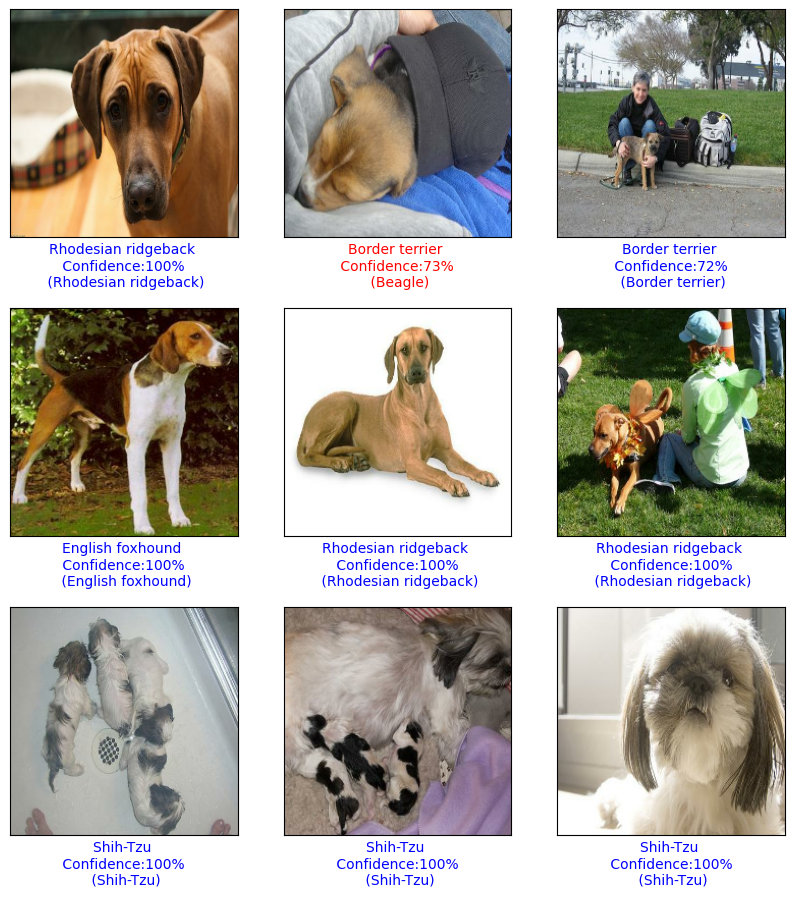

In [28]:
# Represents the a set of images and the predicted label
mpl.figure(figsize=(10, 11))
for i in range(9):
    mpl.subplot(3, 3, i + 1)
    mpl.grid(False)
    mpl.xticks([])
    mpl.yticks([])
    mpl.imshow(image_batch[i].astype("uint8"))

    if predictions_index[i] == label_batch[i]:
        color = 'blue'
    else:
        color = 'red'

    mpl.xlabel("{} \n Confidence:{:2.0f}% \n ({})".format(
        class_names[predictions_index[i]],
        100*np.max(predictions[i]),
        class_names[label_batch[i]]),
        color=color
    )

## Creating the adversarial image pattern

In [29]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label, noise_factor=0.1):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = loss_object(input_label, prediction)

    # Get the gradients of the loss w.r.t to the input image
    gradient = tape.gradient(loss, input_image)
    
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    signed_grad = tf.image.resize(signed_grad, IMG_SIZE)

    # Add more noise to the adversarial pattern
    noisy_signed_grad = signed_grad + noise_factor * tf.random.normal(tf.shape(signed_grad))

    return signed_grad

In [30]:
def fgsm_attack(image_index):        
    image = (np.expand_dims(image_batch[image_index], 0))
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image_probs = model.predict(image, verbose=0)
    # image = (image / 127.5) - 1.0 # Convert the image to [-1,1] range
    
    label = label_batch[image_index]
    label = tf.one_hot(image_index, image_probs.shape[-1])
    label = tf.reshape(label, (1, image_probs.shape[-1]))

    # Create the perturbation pattern
    perturbations = create_adversarial_pattern(image, label)

    # Convert perturbations to the range [0, 255]
    perturbations = (perturbations + 1.0) * 127.5
    #perturbations = tf.round(perturbations)
    #perturbations = tf.cast(perturbations, dtype=tf.float)
    
    mpl.imshow(perturbations[0].numpy().astype("uint8")) # Uncommnet for debug purposes, i.e, visualise the perturbation
    
    return (image, perturbations, image_probs)

In [31]:
def get_stats(image):
    image = (np.expand_dims(image, 0))
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    # image = (image / 127.5) - 1.0 # Convert the image to [-1,1] range
    image_probs = model.predict(image, verbose=0)
    
    label = class_names[np.argmax(image_probs)]
    confidence = 100*np.max(image_probs)
    return (label, confidence, np.argmax(image_probs))

In [32]:
def display_images(image, description, label, confidence, image_index, adv_label_num):
    mpl.figure()
    mpl.imshow(image[0].numpy().astype("uint8"))
    mpl.title('{} \n {} : {:.2f}% Confidence'.format(description, label, confidence))
    # mpl.savefig(f"Figures/FGSMDataset-Epsilon0160-PNGs/{image_index:05}_{adv_label_num}.png", bbox_inches='tight')
    mpl.show() # Uncommnet for debug purposes, i.e, visualise the different levels of perturbations
    mpl.close()

#### Using the pattern to create the adversarial image

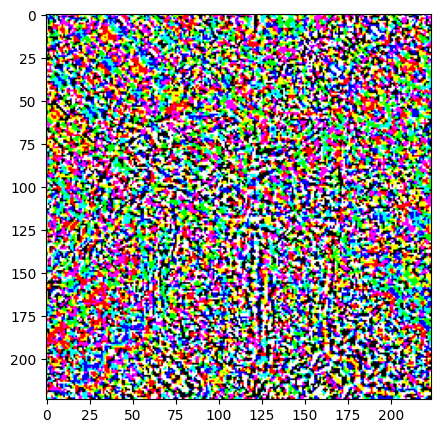

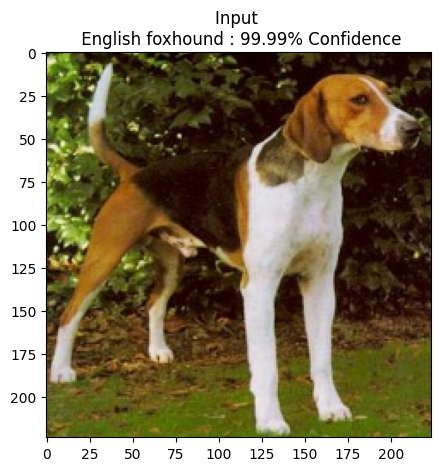

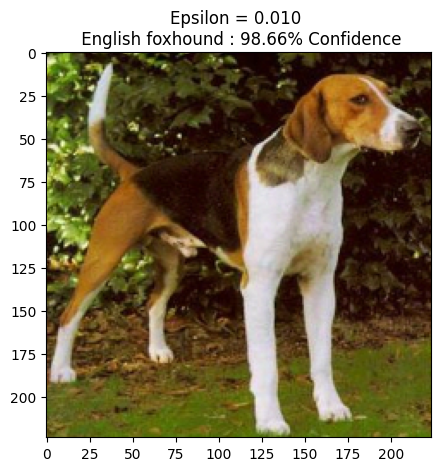

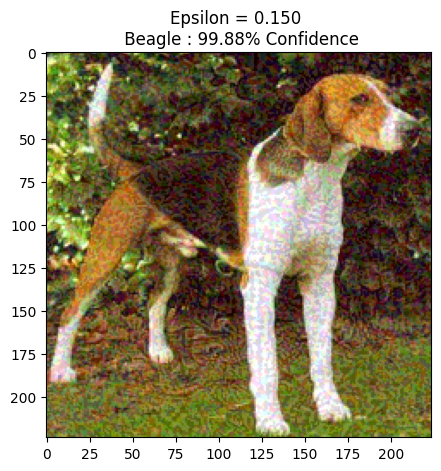

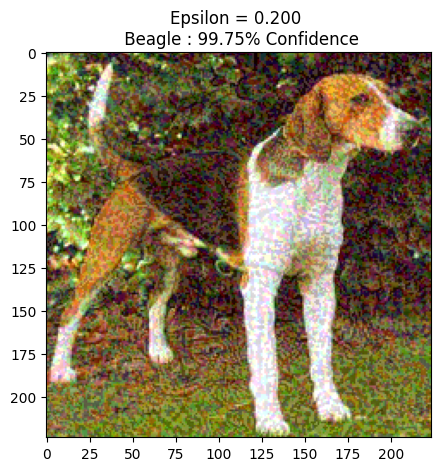

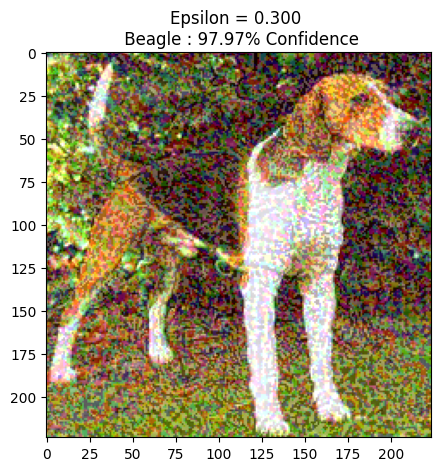

In [35]:
epsilons = [0, 0.01, 0.15, 0.2, 0.3]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input') for eps in epsilons]

image_index = 3
image, perturbations, image_probs = fgsm_attack(image_index)

for i, eps in enumerate(epsilons):  
    adv_x = image+eps*perturbations
    adv_x = tf.clip_by_value(adv_x, 0, 255)
    label, confidence, _ = get_stats(adv_x[0])
    display_images(adv_x, descriptions[i], label, confidence, image_index, _)

#### Creation of the FGSM dataset

In [ ]:
epsilon = 0.16
# epsilon = 0.1

description = 'Epsilon = {:0.3f}'.format(epsilon)

adversarial_images = []
misclassified_labels = []

# for i in range(len(train_images)):
for i in range(10000):
    image_index = i
    image, perturbations = fgsm_attack(image_index)

    # Creation of the adversarial image
    adv_x = image+epsilon*perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    
    id = len(adversarial_images) + 1
    label_name, confidence, label_num = get_stats(adv_x[0])
    
    # Check if the label is misclassified
    original_label_name, _, original_label_num = get_stats(image[0])
    
    print(f"[INFO] FGSM Perturbation ({epsilon:0.3f}): Figure {image_index:05} - Original Label ({original_label_num}:{original_label_name}); FGSM Label ({label_num}:{label_name})")

    if label_num != original_label_num:
        adversarial_label_num = 10*1+original_label_num
    
        adversarial_images.append(adv_x)
        misclassified_labels.append(adversarial_label_num)
        
        display_images(adv_x, description, label_name, confidence, image_index, adversarial_label_num)

# Convert the lists to numpy arrays
adversarial_images = np.array(adversarial_images)
misclassified_labels = np.array(misclassified_labels)

# Save the dataset to a .npz file
# np.savez('FGSMDataset/Dataset.npz', adversarial_images=adversarial_images, misclassified_labels=misclassified_labels)